<a href="https://colab.research.google.com/github/SonOf1998/COVID-19_detection_in_lungs/blob/nandor_workspace/ResNet152V2_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download datasets from Github repository
Our repository: https://github.com/SonOf1998/COVID-19_detection_in_lungs

We download the content of our repository which contains the datasets we collected and cleaned beforehand.

In [1]:
import os
from urllib.request import urlretrieve
import requests
import zipfile
import shutil
import random

In [2]:
working_dir = os.getcwd()
local_zip = os.path.join(working_dir, 'main.zip')

url = 'https://github.com/SonOf1998/COVID-19_detection_in_lungs/archive/main.zip'
urlretrieve(url,local_zip) # Load content of repository into a local zip file

# Extract zip file
zip_ref = zipfile.ZipFile(local_zip,'r') 
zip_ref.extractall()
zip_ref.close()

# Discard zip file
if os.path.exists(local_zip):
  os.remove(local_zip)

In [3]:
repo_root_dir = os.path.join(working_dir, 'COVID-19_detection_in_lungs-main')   # Path to the downloaded directory

# Remove unnecessary files
if os.path.exists(os.path.join(repo_root_dir, 'COVIDDetector.ipynb')):
  os.remove(os.path.join(repo_root_dir, 'COVIDDetector.ipynb'))
if os.path.exists(os.path.join(repo_root_dir, 'LICENSE')):
  os.remove(os.path.join(repo_root_dir, 'LICENSE'))
if os.path.exists(os.path.join(repo_root_dir, 'README.md')):
  os.remove(os.path.join(repo_root_dir, 'README.md'))

In [4]:
# Move dataset directory to working directory
source = os.path.join(repo_root_dir, 'image_datasets')
shutil.move(source, working_dir)

# Remove repository root directory
os.rmdir(repo_root_dir)

# Path to the moved dataset directory
datasets_dir = os.path.join(working_dir, 'image_datasets')

We print out the number of train and test images to check how much data we have.

In [5]:
train_images_dir = os.path.join(datasets_dir, 'train_image_dataset')
test_images_dir = os.path.join(datasets_dir, 'test_image_dataset')

train_covid_images_dir = os.path.join(train_images_dir, 'covid_19')
train_no_findings_images_dir = os.path.join(train_images_dir, 'no_findings')
train_pneumonia_images_dir = os.path.join(train_images_dir, 'pneumonia')

test_covid_images_dir = os.path.join(test_images_dir, 'covid_19')
test_no_findings_images_dir = os.path.join(test_images_dir, 'no_findings')
test_pneumonia_images_dir = os.path.join(test_images_dir, 'pneumonia')

print('train images: {}'.format(len(os.listdir(train_covid_images_dir))+len(os.listdir(train_no_findings_images_dir))+len(os.listdir(train_pneumonia_images_dir))))
print('train covid images: {}'.format(len(os.listdir(train_covid_images_dir))))
print('train no findings images: {}'.format(len(os.listdir(train_no_findings_images_dir))))
print('train pneumonia images: {}'.format(len(os.listdir(train_pneumonia_images_dir))))

print('test images: {}'.format(len(os.listdir(test_covid_images_dir))+len(os.listdir(test_no_findings_images_dir))+len(os.listdir(test_pneumonia_images_dir))))
print('test covid images: {}'.format(len(os.listdir(test_covid_images_dir))))
print('test no findings images: {}'.format(len(os.listdir(test_no_findings_images_dir))))
print('test pneumonia images: {}'.format(len(os.listdir(test_pneumonia_images_dir))))

train images: 1269
train covid images: 370
train no findings images: 449
train pneumonia images: 450
test images: 137
test covid images: 37
test no findings images: 50
test pneumonia images: 50


# Preparing datasets
We are going to use ImageDataGenerators to load images directly from the train and test directories while doing augmentation on the training set simultaneously.

In [6]:
img_height = 256    # Input image height
img_width = 256     # Input image width
batch_size = 32
class_mode = 'categorical'  # 3 categories: covid_19, pneumonia, no_findings
color_mode = 'rgb'  # We use black and white chest xrays

## Data augmentation and splitting data into train, validation and test batches
In order to create more training data we allow the corresponding ImageDataGenerator to generate new instances by slightly rotating and zooming the original images. We also enable horizontal flipping and large scaled adjustments on brightness because it's reasonable to do so while working with data like that.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# min-max normalization and 20% validation split of train datasets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, 
                                  rotation_range=5, zoom_range=0.075, 
                                  brightness_range=[0.2, 1.4], 
                                  horizontal_flip=True)

# generate training batches from train directory 
train_iter = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode = class_mode,
    color_mode = color_mode,
    seed = 42,
    shuffle = True,
    subset='training'
)

# generate validation batches from train directory
validation_iter = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(img_height, img_width),
    batch_size = batch_size,
    class_mode = class_mode,
    color_mode = color_mode,
    shuffle = False,
    subset='validation'
)

# min-max normalization of test datasets
test_datagen = ImageDataGenerator(rescale=1./255)

# generate test batches from test directory
test_iter = test_datagen.flow_from_directory(
    test_images_dir,
    target_size=(img_height, img_width),
    batch_size = 1,
    class_mode = class_mode,
    color_mode = color_mode,
    shuffle = False
)

Found 1016 images belonging to 3 classes.
Found 253 images belonging to 3 classes.
Found 137 images belonging to 3 classes.


# Data visualization
We visualize an augmented batch of data.

In [8]:
import numpy as np

iter = train_iter.next()    # Get the first batch of preprocessed images
xrays = iter[0]
labels = iter[1]  # One-hot encoding: 
                  # [1, 0, 0] - covid_19, 
                  # [0, 1, 0] - no_findings, 
                  # [0, 0, 1] - pneumonia

In [9]:
train_iter.class_indices

{'covid_19': 0, 'no_findings': 1, 'pneumonia': 2}

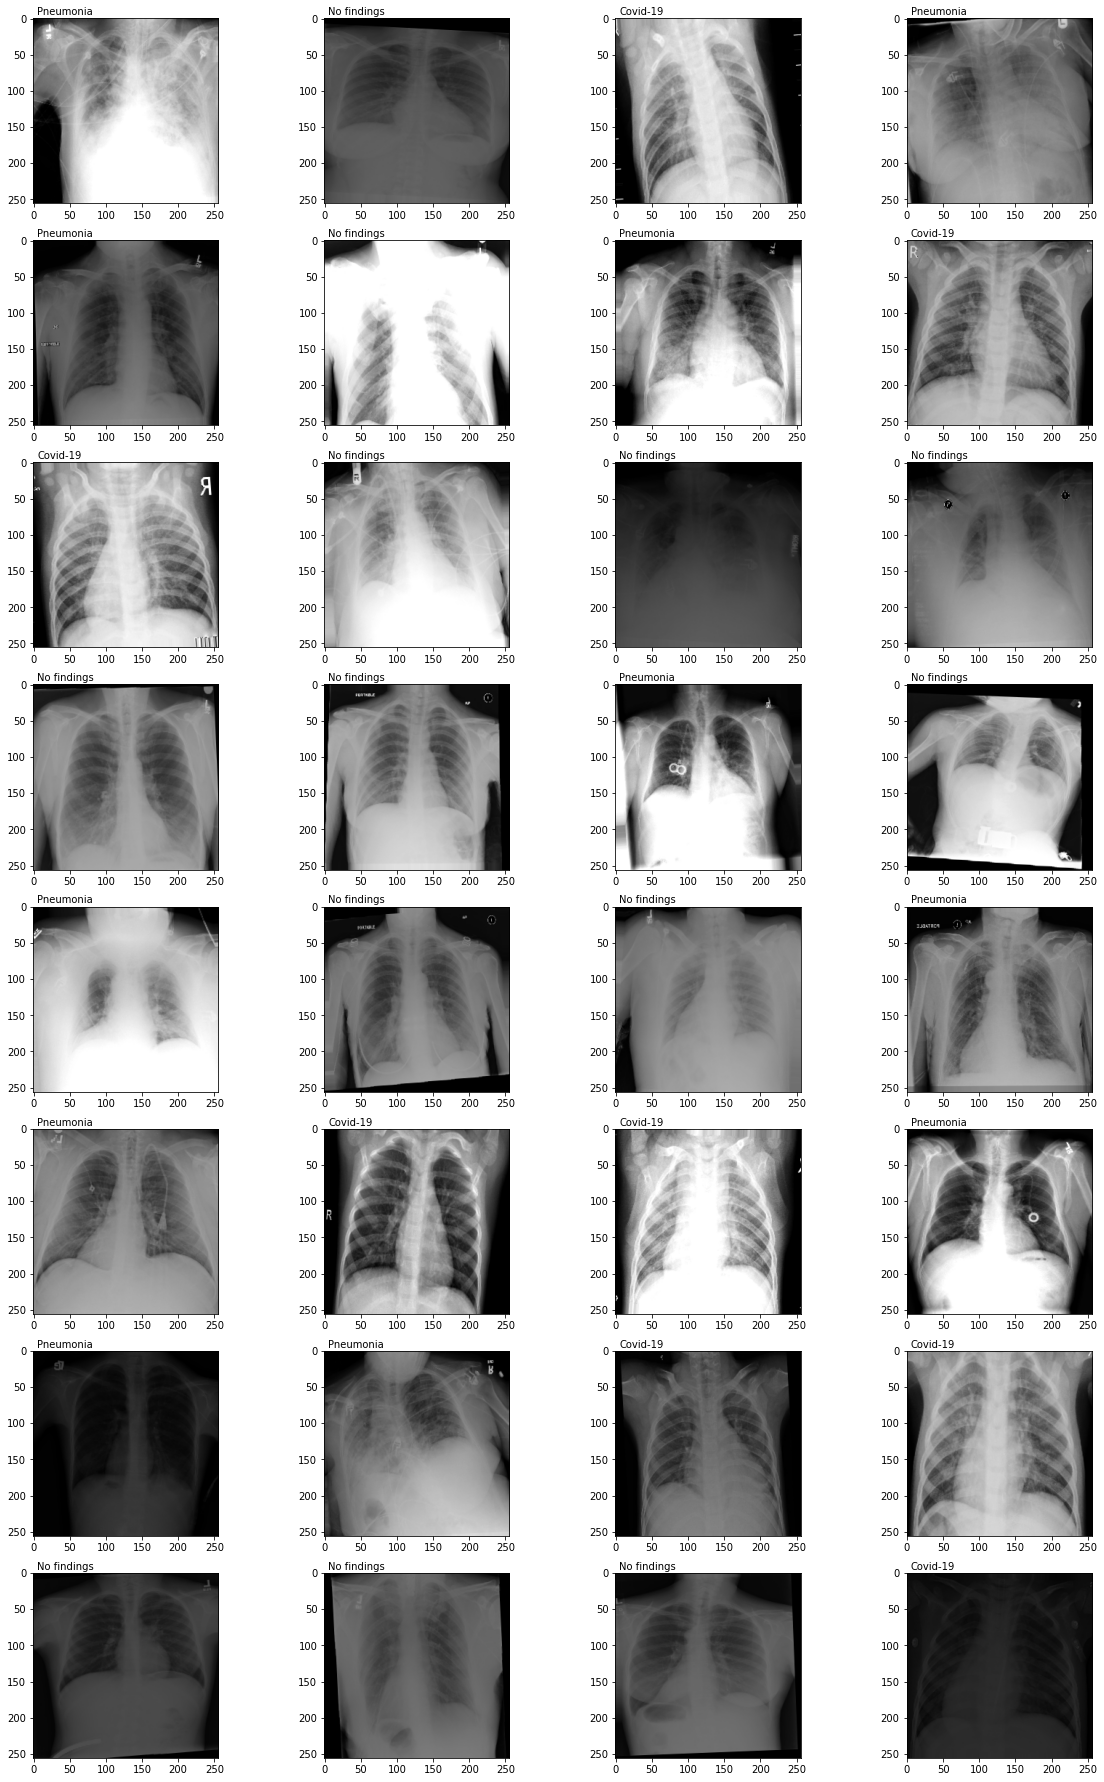

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

ncols = 4 # Preferred amount of columns
nrows = int(np.ceil(xrays.shape[0]/ncols)) # Calculate num of rows based on batch size

fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 4)

# Plot
for i, img in enumerate(xrays):
  sp = plt.subplot(nrows, ncols, i + 1)
  plt.imshow(img, cmap='gray')
  if(labels[i][0] == 1):
    plt.text(x = 5, y = -5, s='Covid-19')
  elif(labels[i][1] == 1):
    plt.text(x = 5, y = -5, s='No findings')
  elif(labels[i][2] == 1):
    plt.text(x = 5, y = -5, s='Pneumonia')
plt.show()

In [11]:
# Reset the iterator
train_iter.reset()
train_iter.total_batches_seen = 0

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

base_model.trainable = False

In [21]:
checkpoint_path = "best_model.chk"

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
cp = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

model.compile(optimizer='adam', metrics=['accuracy'], loss = 'categorical_crossentropy')

In [22]:
model.fit(
    train_iter,
    epochs=10000,
    validation_data=validation_iter,
    callbacks=[cp, es]) 

Epoch 1/10000
32/32 [==============================] - ETA: 0s - loss: 0.9742 - accuracy: 0.5955
Epoch 00001: val_accuracy improved from -inf to 0.62451, saving model to best_model.chk
32/32 [==============================] - 49s 2s/step - loss: 0.9742 - accuracy: 0.5955 - val_loss: 0.8186 - val_accuracy: 0.6245
Epoch 2/10000
32/32 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.7933
Epoch 00002: val_accuracy improved from 0.62451 to 0.64427, saving model to best_model.chk
32/32 [==============================] - 45s 1s/step - loss: 0.4718 - accuracy: 0.7933 - val_loss: 0.8317 - val_accuracy: 0.6443
Epoch 3/10000
32/32 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8199
Epoch 00003: val_accuracy improved from 0.64427 to 0.69960, saving model to best_model.chk
32/32 [==============================] - 46s 1s/step - loss: 0.4069 - accuracy: 0.8199 - val_loss: 0.7059 - val_accuracy: 0.6996
Epoch 4/10000
32/32 [==============================]

In [23]:
model.load_weights(checkpoint_path)

for layer in model.layers[302:]:
    layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'], loss='categorical_crossentropy')

In [24]:
model.fit(
    train_iter,
    epochs=10000,
    validation_data=validation_iter,
    callbacks=[cp, es]) 

Epoch 1/10000
32/32 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.7539
Epoch 00001: val_accuracy did not improve from 0.75889
32/32 [==============================] - 51s 2s/step - loss: 0.5679 - accuracy: 0.7539 - val_loss: 0.6919 - val_accuracy: 0.7431
Epoch 2/10000
32/32 [==============================] - ETA: 0s - loss: 0.4455 - accuracy: 0.8061
Epoch 00002: val_accuracy did not improve from 0.75889
32/32 [==============================] - 48s 1s/step - loss: 0.4455 - accuracy: 0.8061 - val_loss: 0.8281 - val_accuracy: 0.6957
Epoch 3/10000
32/32 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8110
Epoch 00003: val_accuracy did not improve from 0.75889
32/32 [==============================] - 48s 1s/step - loss: 0.4134 - accuracy: 0.8110 - val_loss: 0.7623 - val_accuracy: 0.7115
Epoch 4/10000
32/32 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8593
Epoch 00004: val_accuracy did not improve from 0.75889
32/32

In [25]:
model.load_weights(checkpoint_path)

loss, acc = model.evaluate(test_iter)
print(acc)

137/137 [==============================] - 5s 37ms/step - loss: 0.4158 - accuracy: 0.8102
0.8102189898490906
